In [ ]:
# This notebook uses the same examples used in "2023-05-31 thermodynamic environment tests" from TC Sam for testing.
# hopefully, by taking a case by case approach, cloud types can be determined empirically for all passes!

In [ ]:
# goal 2: classify cloud clusters as either being stratiform or convective by using a few different flags.
# -flag 1: use cloud height. Three ways: 
#          way 1: use dropsondes / crl to define the inversion layer. Anything above -> convective
#          way 2: anything over an arbitrary height (ex 2 km) is convective
#          way 3: if there's a defined lower peak in the cloud distributions, call that the inversion level. Anything above
#                 -> convective
# -flag 2: use cloud top variation. Stratiform clouds should have less top variation. Maybe calculate standard deviations for 
#          known convective / stratiform clouds, and see if they differ?
# -flag 3: optical depth. Some stratiform clouds are thinner than convective clouds. Calculate how long it takes signal to
#          attenuate in strat / convect clouds... any differences?

In [16]:
# import...
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023
sys.path.append("/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata
import find_cloud_tops
import find_cloud_clusters


In [109]:
# general: start by looking at TC sam because this dataset is generally much more well behaved than others.
# then, expand these techniques to other TCs!
year = '2021'
date = '0929'
eye_pass = 0
profile_list = [25, 70, 85, 100, 110, 117, 125, 174]

if date == '0926':
    crl_file = 'P3_20210926H1_processed.nc'
    crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
    os.chdir(crl_path)
    crl_data = xr.open_dataset(crl_file)
    # time limits (different for each day)
    lim0, lim1 =  22.25, 25.75

elif date == '0927':
    crl_file = 'P3_20210927H1_processed.nc'
    crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
    os.chdir(crl_path)
    crl_data = xr.open_dataset(crl_file)
    # time limits (different for each day)
    lim0, lim1 = 21.6, 25.75

elif date == '0929':
    crl_file = 'P3_20210929H2_processed.nc'
    crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
    os.chdir(crl_path)
    crl_data = xr.open_dataset(crl_file)
    # time limits (different for each day)
    lim0, lim1 = 21.25, 26.2
    
    eyesondes = ['D20210929_213712QC.FRD', 'D20210929_224939QC.FRD']


In [110]:
# make simple plots of crl and fl data

# setup info
lw = 2
fs = 18
use_limit = True
zoom = True

crllim0 = np.nanargmin( np.abs(crl_data.time - lim0 ))
crllim1 = np.nanargmin( np.abs(crl_data.time - lim1 ))

# next goal: get mean values just within CRL eye limits
metadata = eyewall_metadata.all_metadata()
lims = metadata[year]['eyewall_limits'][date][eye_pass]
eyelim0, eyelim1 = lims[0], lims[1]
crleyelim0 = np.nanargmin( np.abs(crl_data.time - eyelim0 ))
crleyelim1 = np.nanargmin( np.abs(crl_data.time - eyelim1 ))

print(crleyelim0)
print(crleyelim1)

# zoom in or not:
if zoom:
    crllim0, crllim1 = crleyelim0, crleyelim1
    fllim0, fllim1 = fleyelim0, fleyelim1

crlfield = crl_data.P_ch1[ crllim0:crllim1, :].transpose()
ylabel = "Power Ch. 1 (dBz)"
vmax = 30

# cloud height preparation
metadata = eyewall_metadata.all_metadata()
pairval = metadata[ year]['eyewall_limits'][ date][eye_pass]
lefteyewall, righteyewall = pairval[ 0], pairval[ 1]
li = np.argmin( np.abs(crl_data.time.values - lefteyewall))
ri = np.argmin( np.abs(crl_data.time.values - righteyewall))
print(lefteyewall)
print(righteyewall)
print(li)
print(ri)

H = crl_data.height
power = crl_data.P_ch1[ li:ri, :]
axis = crl_data.time[ li:ri]
p3_height = crl_data.p3_height[ li:ri]

# get cloud heights and clusters
cloudheights, cloudtime = find_cloud_tops.find_cloud_heights( H, power, axis, p3_height, cutoff_power = -30)
cluster_threshold=250
surface_threshold=50
min_size=2
low_pass_filt=False
combine_clusters=False
H_clusters, xaxis_clusters = find_cloud_clusters.clusters_within_threshold_updated( cloudheights, axis, cluster_threshold, surface_threshold, min_size=min_size, combine_clusters=combine_clusters)

# find mean cloud cluster heights
mean_heights = [] 
cluster_means = []

# do this for every cloud cluster
for i in range( len( H_clusters)):
    cluster_mean = np.nanmean( np.array( H_clusters[ i]))
    
    # if not np.isnan( cluster_mean):
    cluster_means.append( cluster_mean / 1000. )
    mean_heights.append( [ cluster_mean] * len( H_clusters[ i] ) )

# find cloud cluster horizontal sizes
cluster_size = []
for i in range( len( H_clusters)):
    cluster_mean = np.nanmean( np.array( H_clusters[ i]))    
    # if not np.isnan( cluster_mean):
    cluster_size.append( ((2 * 130) / 1000) * len( H_clusters[i]))
    
print(cluster_means)
print(cluster_size)

print(len(cluster_means))
print(len(cluster_size))

680
861
21.5788
21.6793
680
861
[0.9986505129754228, 0.6396813756711927, 0.6336126446833908, 0.8327110330172316, 2.264039452519411, 0.9677099201118086, 1.8600282130453805, 2.3975058041683526, 2.3246921623496974, 2.4243376608762253, 2.1049726176952803, 1.7455424978098806, 1.1066994288429641, 2.5579830938787014, 2.4917481106143735, 1.4947392806933393, 2.468356900959407, 1.518830609997516, 2.244177293439383, 1.9110110108236018, 2.2690287817054005, 1.685272834600374, 2.42765208009441, 1.2439742699680851]
[1.56, 1.04, 1.04, 2.08, 3.12, 0.78, 0.78, 1.04, 3.64, 1.56, 1.04, 0.52, 3.12, 1.04, 1.04, 0.52, 3.38, 1.56, 3.9000000000000004, 0.52, 1.82, 0.78, 2.6, 1.82]
24
24


Text(0.5, 0, 'Time (Hours, UTC)')

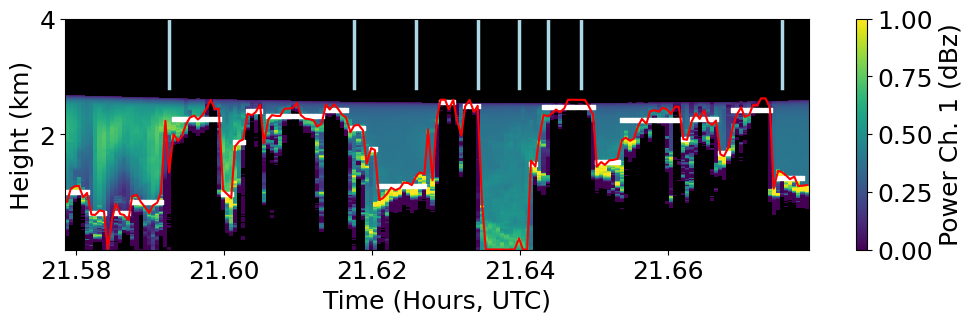

In [111]:
# make figure
plt.figure(figsize=(12,3))
helper_fns_winter2023.change_font_sizes(fs, fs)

plt.plot( cloudtime, cloudheights / 1000., c='r', label='Cloud Heights')

plt.pcolormesh( crl_data.time[crllim0:crllim1], crl_data.height / 1000, crlfield, vmin=-30, vmax=-10)

for i in range( len( H_clusters)):
    if i == 0:
        plt.scatter( xaxis_clusters[ i], np.array( mean_heights[ i]) / 1000. , c='w', marker='s', s=5, label='Cloud Clusters')
    else:
        plt.scatter( xaxis_clusters[ i], np.array( mean_heights[ i]) / 1000. , c='w', marker='s', s=5)

# add vertical profile lines here
for i, val in enumerate( profile_list):
    if i == 0:
        plt.axvline( cloudtime[val], ymin=.7, ymax=1, c='lightblue', linewidth=2.5, label='Vertical Profiles')
    else:
        plt.axvline( cloudtime[val], ymin=.7, ymax=1, c='lightblue', linewidth=2.5)
        
cbar = plt.colorbar()
cbar.ax.set_ylabel( ylabel=ylabel)
# plt.legend(loc='upper right', framealpha=1., fontsize=fs/1.5)
cbar.ax.tick_params(labelsize=fs)
plt.ylabel( 'Height (km)')
ax = plt.gca()
ax.set_facecolor('k')
plt.xlabel("Time (Hours, UTC)")



In [112]:
# flag 2: sort clusters by cloud top variations / standard deviations

stds = []
flag2 = []
for clusteri, clusterval in enumerate( H_clusters):
    stds.append( np.std( clusterval))
    if np.std(clusterval) > 100:
        flag2.append(1)
    else:
        flag2.append(0)
        
print(stds)
print(np.max(stds))
print(flag2)

# standard deviation distribution for each height case
# bw1 = 25
# xinc1 = np.arange(0,300,bw1)
# hx=np.histogram( stds,xinc1)
# plt.rcParams["figure.figsize"] = [5,5]
# plt.bar(hx[1][:-1],hx[0],edgecolor = 'k', color = 'g', width = bw1, linewidth = 1)


[102.23988838690464, 34.5420559954636, 105.029752075727, 111.3080211978752, 209.97694962561116, 56.51548380641486, 52.158106001726125, 70.10076859629667, 109.77529057405664, 84.34365420190039, 53.911085895414, 15.36615565864281, 146.81229901190565, 72.9595168156626, 74.82566921820256, 50.70353523973722, 112.29272701331371, 48.42560908574972, 220.9952802893796, 5.345012894111278, 83.17477199636859, 67.36856416705447, 146.1334464593743, 96.880545551772]
220.9952802893796
[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]


In [113]:
# flag 1: sort cloud clusters by mean height: convective are taller

flag1 = np.zeros(len(cluster_means))
flag1[ np.where( np.array(cluster_means) > 1.5)[0]] = 1

print(cluster_means)
print(flag1)

[0.9986505129754228, 0.6396813756711927, 0.6336126446833908, 0.8327110330172316, 2.264039452519411, 0.9677099201118086, 1.8600282130453805, 2.3975058041683526, 2.3246921623496974, 2.4243376608762253, 2.1049726176952803, 1.7455424978098806, 1.1066994288429641, 2.5579830938787014, 2.4917481106143735, 1.4947392806933393, 2.468356900959407, 1.518830609997516, 2.244177293439383, 1.9110110108236018, 2.2690287817054005, 1.685272834600374, 2.42765208009441, 1.2439742699680851]
[0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]


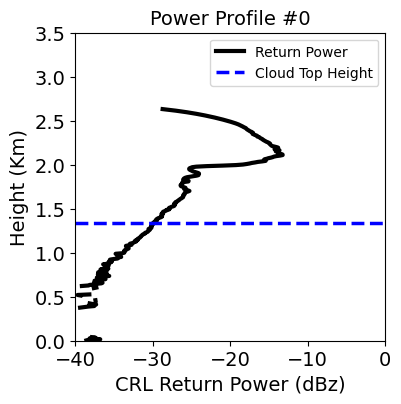

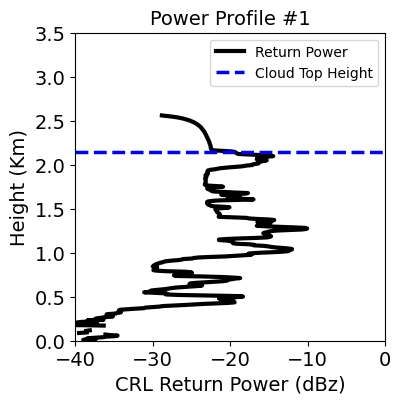

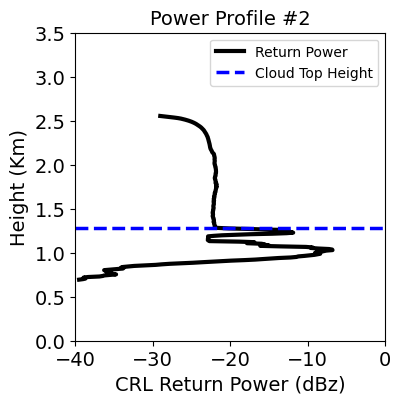

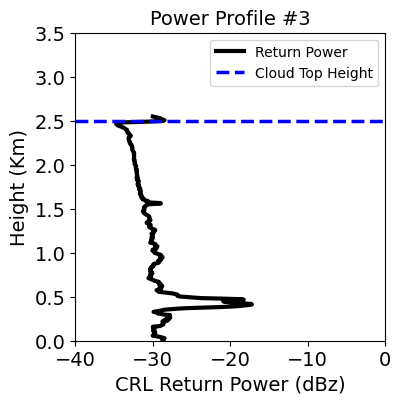

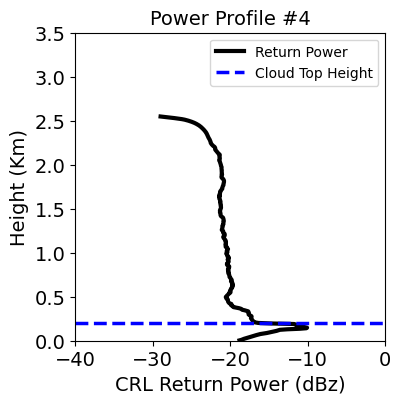

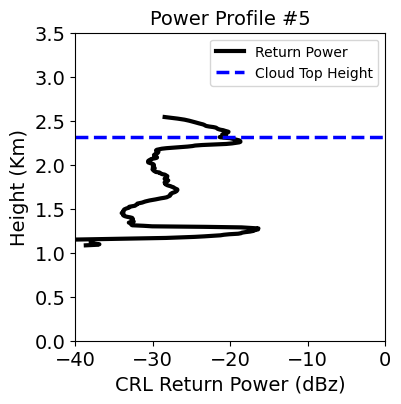

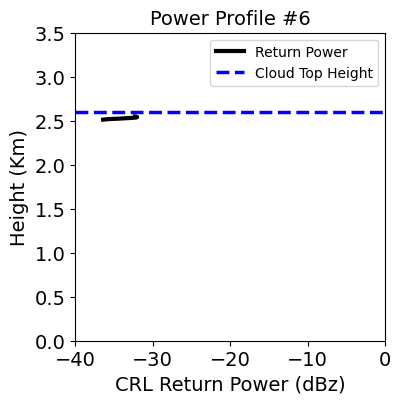

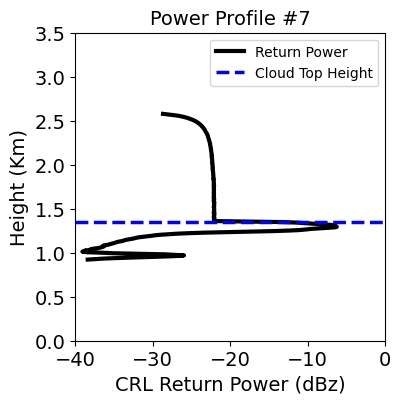

In [114]:
# flag 3: sort by cloud optical thickness
# this method is a bit trickier!
# first, plot some cloud backscatter returns from stratiform vs convective clouds

for i, profile in enumerate( profile_list):
    cloudtop = cloudheights[profile] / 1000
    plt.figure( figsize=( 4, 4))
    helper_fns_winter2023.change_font_sizes(small=14, medium=14)
    plt.xlabel( "CRL Return Power (dBz)")
    plt.title( "Power Profile #" + str(i))
    plt.ylabel("Height (Km)")
    
    plt.plot( crlfield[:, profile], crl_data.height / 1000, c='k', linewidth=3, label='Return Power')
    plt.axhline( y= cloudtop, c='b', linewidth=2.5, alpha=1, label='Cloud Top Height', linestyle='--')
    plt.legend(loc='upper right', fontsize=10)

    plt.ylim([0, 3.5])
    plt.xlim([-40, 0])